In [158]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from dynesty import NestedSampler
from dynesty import plotting as dyplot
import time
import os

In [109]:
import dill
import dynesty.utils
dynesty.utils.pickle_module = dill

In [69]:
%load_ext line_profiler

# Write out the likelihood 
The likelihood of each of the $x,y$ points which I will write as $d$. I assume a gaussian lieklihood on the center of the points, this includes errors from measuerment and manufacturing.
The parameters which describe the circle are the centre point of the circle (may need to update this to have a parameter for the center for each segment), the radius of the circle $R$, the phase offset of the first point from the x axis $\phi$, there is also a parameter for the starting index for each segment $s$. Finally there is N which is the number of points in the circle.

The posterior on each of these parameters can be computed with bayes theorem written as
$$
p(\theta | d, N) = \frac{p(\theta | N)p(d | \theta, N)}{p(d | N)}
$$
The likelihood can be written as
$$
p(d | \theta, N) = \prod_s \prod_i \frac{1}{\sqrt{2\pi  \sigma^2}} \exp{\left( - \frac{(x_i - X_i(\theta, s))^2 - (y_i - Y_i(\theta, s))^2}{2\sigma^2}\right)},
$$
where the X and Y are the model for the x and y position in a circle.
They are defined by:
$$
X_i(\theta, s) = R\cos{\left( 2\pi (k_i + s) /N + \phi \right)} + x_c
$$
and 
$$
Y_i(\theta, s) = R\sin{\left( 2\pi (k_i + s) /N + \phi \right)} + y_c,
$$
where $k$ is an integer number of points around the circle and $s$ is the offset of the starting point for a segment.

For a suitably defined prior (Below a uniform prior on all parameters is used) one can compute the evidence $p(d | N$ using nested sampling.
This is equaivalent to the likelihood for a different form of Bayes formula,
$$
p(N | d) = \frac{p(N)p(d|N)}{p(d)}.
$$
Where assuming a flat prior on N, the likelihood is proportional to the posterior on N.
$$
p(N | d) \propto p(d | N).
$$

Below the evidence is computed for many nested sampling runs at different values of N.

In [182]:
def model(x, y, R, phis, xcent, ycent, phase):

    phi = phis + phase

    cphi = np.cos(phi)
    sphi = np.sin(phi)

    # compute model points in x,y
    r_x = R*cphi
    r_y = R*sphi

    # shift data point to be around model x,y
    d_x = x - xcent
    d_y = y - ycent

    # find error vector between data and model
    e_x = r_x - d_x
    e_y = r_y - d_y

    # project vector into radius and tangent
    rp = e_x*cphi + e_y*sphi
    tp = e_x*sphi - e_y*cphi

    return rp, tp

def log_likelihood(params, data, N):
    R, sigma_r, sigma_t = params[:3]
    phases, xcents, ycents = np.split(params[3:], 3)
    #x,y = data

    invsig_r = 1./(2*(sigma_r*sigma_r))
    invsig_t = 1./(2*(sigma_t*sigma_t))

    npoints = np.sum([len(dt) for dt in data])
    prefact = 0#-npoints*np.log(2*np.pi*sigma_t*sigma_r)
    phis = 2*np.pi*np.arange(100)/N

    #k = np.arange(N)
    exp_likelihood = 0
    for i, sect in enumerate(data):
        x,y = sect

        # assume independent r, tangent
        rp, tp = model(x, y, R, phis[:len(x)], xcents[i], ycents[i], phases[i])

        exponent = -invsig_r*(rp**2) - invsig_t*(tp**2)

        exp_likelihood += np.sum(len(x)*np.log(2*np.pi*sigma_t*sigma_r) - exponent)


    return prefact + exp_likelihood




In [4]:
def log_prior(params, N):
    R, phase, sigma = params[:3]
    ks = params[3:]
    angle = 2*np.pi/N 
    if 8 < N < 12 and -angle < phase < angle and 1 < R < 15 and np.all(ks) < N and 0<sigma < 1:
        return 1/params[0]
    else:
        return -np.inf

In [5]:
def log_posterior(p, data, N):
    p = np.insert(p,0,N)
    lnp = log_prior(p, N)
    if np.isfinite(lnp):
        return lnp + log_likelihood(p, data, N)
    return lnp

In [6]:
def get_data(N, R, phase, kstarts, sigma, npoints):

    data = []
    for i, kst in enumerate(kstarts):
        ks= np.arange(npoints[i]) + kst
        x,y = model(N, R, phase, ks)

        x = x + np.random.normal(0, sigma, size=len(x))
        y = y + np.random.normal(0, sigma, size=len(x))
        data.append([x,y])

    return data

# Antikithera mechanism

Load antikethira mechanism data

In [183]:
root_dir = "./graham_wrong_likelihood/"
if not os.path.isdir(root_dir):
    os.makedirs(root_dir)

In [7]:
import pandas

In [8]:
data = pandas.read_csv("./1-Fragment_C_Hole_Measurements.csv")

In [9]:
data_col = data[["Section ID", "Mean(X)", "Mean(Y)"]]

Group the data into each of the measured sections

In [10]:
data_groupeddf = data_col.groupby(data_col["Section ID"])[["Mean(X)", "Mean(Y)"]].agg(lambda x: x.tolist()).values

In [11]:
data_groupeddf

array([[list([15.59931]), list([92.59653])],
       [list([16.44167, 17.30764, 18.15278, 18.96528, 19.81389, 20.78611, 21.49722, 22.39931, 23.5125, 24.3125, 25.31736, 26.32083, 27.46389, 28.53125, 29.32083, 30.40278, 31.64028, 32.75069, 33.96945, 35.10938, 36.15139, 37.30972]),
        list([91.50069, 90.34931, 89.1625, 88.14792, 87.06875, 85.96875, 85.03403, 84.07222, 82.90486, 82.04375, 81.06458, 80.05486, 79.04167, 78.00208, 77.30833, 76.37986, 75.4493, 74.56528, 73.67847, 72.88542, 72.11111, 71.29653])],
       [list([38.50764, 39.79306, 40.87708, 42.0625, 43.15972, 44.41528, 45.525, 46.84375, 48.22569]),
        list([70.46944, 69.58333, 68.91944, 68.25972, 67.6375, 66.97569, 66.41111, 65.79792, 65.23542])],
       [list([49.62083, 50.83264, 52.18611, 53.45903, 54.60972, 55.90625, 57.11111, 58.38264, 59.72639, 61.325, 62.52292, 63.90347, 65.06389, 66.49028, 67.90694, 69.3375, 70.60417, 71.9118, 73.34722, 74.71597, 76.0007, 77.53472, 78.7625, 80.23403, 81.44375, 82.88195, 84.17639,

In [12]:
data_grouped = []
for xt, yt in data_groupeddf:
    xn = np.array(xt)
    yn = np.array(yt)
    data_grouped.append([xn, yn])


plot and estimate the center of the circle that passes through all points for prior bounds.

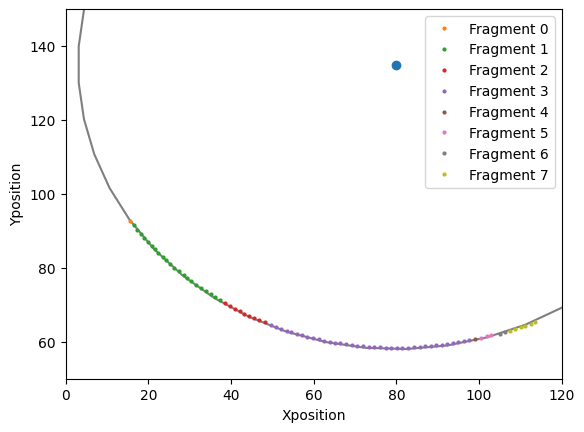

In [13]:
fig, ax = plt.subplots()
xc,yc = 80, 135
r = 77
xcirc = r*np.cos(np.linspace(0,2*np.pi)) + xc
ycirc = r*np.sin(np.linspace(0,2*np.pi)) + yc
ax.plot(xc,yc, "o")
ax.plot(xcirc,ycirc, "k",alpha=0.5)
for i,dt in enumerate(data_grouped):
    ax.plot(dt[0], dt[1], marker="o", ms=2,ls="none",label = f"Fragment {i}")

ax.set_xlabel("Xposition")
ax.set_ylabel("Yposition")
ax.set_xlim([0, 120])
ax.set_ylim([50, 150])
ax.legend(loc="upper right")

In [184]:
nsegments = len(data_grouped)

Set prior bounds

In [185]:
anti_bounds = {
    "R": (60, 100),
    "sigma_r": (0,0.5),
    "sigma_t": (0,0.5),
}
for k in range(nsegments):
    anti_bounds[f"phases{k}"] = (0,2*np.pi)
for k in range(nsegments):
    anti_bounds[f"xcent{k}"] = (70,90)
for k in range(nsegments):
    anti_bounds[f"ycent{k}"] = (130,140)

In [116]:
def prior_transform(u, bounds, plabels):
    r, sigma_r, sigma_t = u[:3]
    ks = u[3:]

    outvals = []
    for i,key in enumerate(plabels):
        outvals.append(u[i]*(bounds[key][1] - bounds[key][0]) + bounds[key][0])

    return outvals

In [186]:
plabels = ["R", "sigma_r", "sigma_t"] + [f"phases{i}" for i in range(nsegments)] + [f"xcent{i}" for i in range(nsegments)] + [f"ycent{i}" for i in range(nsegments)]

In [118]:
len(anti_bounds)

27

In [119]:
pars = np.array([9.28239700e+01, 4.12326788e-01, 1.79755862e-03, 2.82566762e+00,
       1.20700087e-01, 5.19003154e+00, 2.91646265e+00, 1.74461540e+00,
       5.07479451e+00, 3.89067378e+00, 5.19728689e+00, 8.94063986e+01,
       8.43023446e+01, 8.40007045e+01, 8.67134294e+01, 8.53950831e+01,
       8.17241405e+01, 7.83364064e+01, 7.09225254e+01, 1.34455683e+02,
       1.38701471e+02, 1.32524103e+02, 1.33839924e+02, 1.31551842e+02,
       1.36780433e+02, 1.36762590e+02, 1.30273219e+02])
%timeit log_likelihood(pars, data_grouped, 354)

108 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [122]:
%lprun -f log_likelihood log_likelihood(pars, data_grouped, 354)

Timer unit: 1e-09 s

Total time: 0.000286 s
File: /var/folders/5g/x3mq__7j4q19_ymmlzpqqt9c0000gq/T/ipykernel_37469/2402038613.py
Function: log_likelihood at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                           def log_likelihood(params, data, N):
    26         1       8000.0   8000.0      2.8      R, sigma_r, sigma_t = params[:3]
    27         1      54000.0  54000.0     18.9      phases, xcents, ycents = np.split(params[3:], 3)
    28                                               #x,y = data
    29                                           
    30         1       3000.0   3000.0      1.0      invsig_r = 1./(2*(sigma_r**2))
    31         1       1000.0   1000.0      0.3      invsig_t = 1./(2*(sigma_t**2))
    32                                           
    33         1       7000.0   7000.0      2.4      prefact = np.log(2*np.pi*sigma_t * sigma_r)
    34         1      24000.0  24000.0      8.4      vals = 2*np.pi

In [123]:
%lprun -f model model(data_grouped[1][0], data_grouped[1][1], 77, 2*np.pi*np.arange(len(data_grouped[1][0]))/354, 2, 3, 1, 354)

Timer unit: 1e-09 s

Total time: 2.2e-05 s
File: /var/folders/5g/x3mq__7j4q19_ymmlzpqqt9c0000gq/T/ipykernel_37469/2402038613.py
Function: model at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def model(x, y, R, phis, xcent, ycent, phase, N):
     2                                           
     3         1       4000.0   4000.0     18.2      d_x = x - xcent
     4         1       1000.0   1000.0      4.5      d_y = y - ycent
     5                                           
     6         1       3000.0   3000.0     13.6      phi = phis + phase
     7                                           
     8         1       3000.0   3000.0     13.6      cphi = np.cos(phi)
     9         1       2000.0   2000.0      9.1      sphi = np.sin(phi)
    10                                           
    11         1       2000.0   2000.0      9.1      r_x = R*cphi
    12         1       2000.0   2000.0      9.1      r_y = R*sp

In [189]:
anti_logzs = []
anti_samples = []
ndims = 3 + 3*nsegments
Nrange = np.arange(352, 367)#np.array([352, 353, 354, 355, 360])

In [190]:

print(ndims)
for n in Nrange:
    andyll = lambda params: log_likelihood(params, data_grouped, n)
    andypt = lambda params: prior_transform(params, anti_bounds, plabels)

    sampler = NestedSampler(andyll, andypt, ndim=ndims, nlive=250)

    sampler.run_nested(checkpoint_file=os.path.join(root_dir, f'dynesty_{n}.save'))

    res = sampler.results

    anti_logzs.append(res.logz[-1])

27


0it [00:00, ?it/s]

2021it [00:28, 32.66it/s, bound: 15 | nc: 254 | ncall: 233953 | eff(%):  0.864 | loglstar:   -inf < 41862969624969.828 <    inf | logz: 41862969624955.547 +/-    nan | dlogz:    inf >  0.259]/Users/joebayley/miniconda3/envs/general_parest/lib/python3.10/site-packages/dynesty/sampling.py:420: UserWarning: The slice sample interval was expanded more than 1000 times
  warnings.warn('The slice sample interval was expanded more '
/Users/joebayley/miniconda3/envs/general_parest/lib/python3.10/site-packages/dynesty/sampling.py:684: UserWarning: Enabling doubling strategy of slice sampling from Neal(2003)
  warnings.warn('Enabling doubling strategy of slice '
39194it [19:06, 43.16it/s, bound: 638 | nc: 198 | ncall: 9607881 | eff(%):  0.408 | loglstar:   -inf < 5758878542982153975861857412546413460381076267303718031896478067114970546581959397624311640802314085721798017440536670900041075892134002819072.000 <    inf | logz: 5758878542982153975861857412546413460381076267303718031896478067114970546

Exception while calling loglikelihood function:
  params: [95.57903357300808, 5.18578898936615e-69, 0.20156522044584363, 3.218978417317826, 3.887583916197779, 2.4261273190812536, 0.7515240376397445, 2.4036393591406733, 5.257599342314056, 2.9228009027339015, 1.7596137407635017, 74.92810784360317, 76.42802945512052, 83.70076462391833, 74.16569904388896, 78.38920535848791, 83.73101221512887, 78.63319719746804, 80.19298608847957, 130.55431580297713, 137.25458638033882, 133.12374911399402, 137.87214225920926, 137.30153777160922, 133.58856502789058, 136.81511032929532, 139.44532697686077]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [174]:
Ns = []
log_evidences = []
for fname in sorted(os.listdir(root_dir)):
    if fname.startswith("dynesty"):
        n = int(fname.split("_")[1].split(".")[0])
        Ns.append(n)

        t_sampler = NestedSampler.restore(os.path.join(root_dir, fname))
        t_res = t_sampler.results

        log_evidences.append(t_res.logz[-1])

In [175]:
#with open("./g_ll_logzs.txt","w") as f:
#    np.savetxt(f,[Nrange, anti_logzs])

In [176]:
Ns

[352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364]

Plot the evidence as a function if the number of points

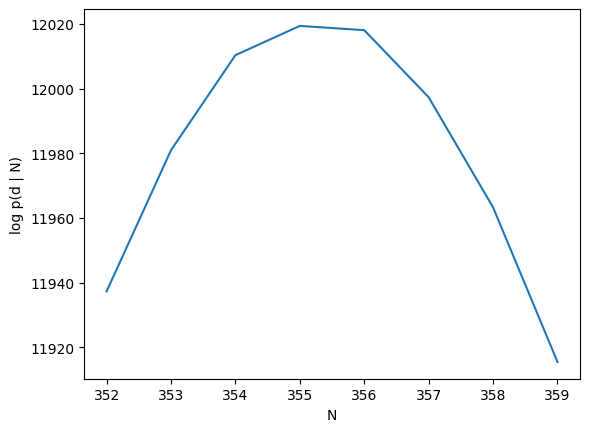

In [179]:
fig, ax = plt.subplots()
sind,eind = 0,8
ax.plot(Ns[sind:eind],log_evidences[sind:eind])
ax.set_xlabel("N")
ax.set_ylabel("log p(d | N)")
fig.savefig(os.path.join(root_dir, "evidences.png"))

Find the maximum evidence

In [152]:
maxN = Nrange[np.argmax(anti_logzs)]
print(maxN)

357


In [137]:
# bayes factor at 360 and 354 (the two plausable ones from the paper)
log_bf = anti_logzs[np.where(Nrange == 360)[0][0]] - anti_logzs[np.where(Nrange == 354)[0][0]]
print(log_bf)

-149.2212612467738


In [192]:
fsampler = NestedSampler.restore(f'./graham_likelihood/dynesty_{354}.save')

In [193]:
fres = fsampler.results

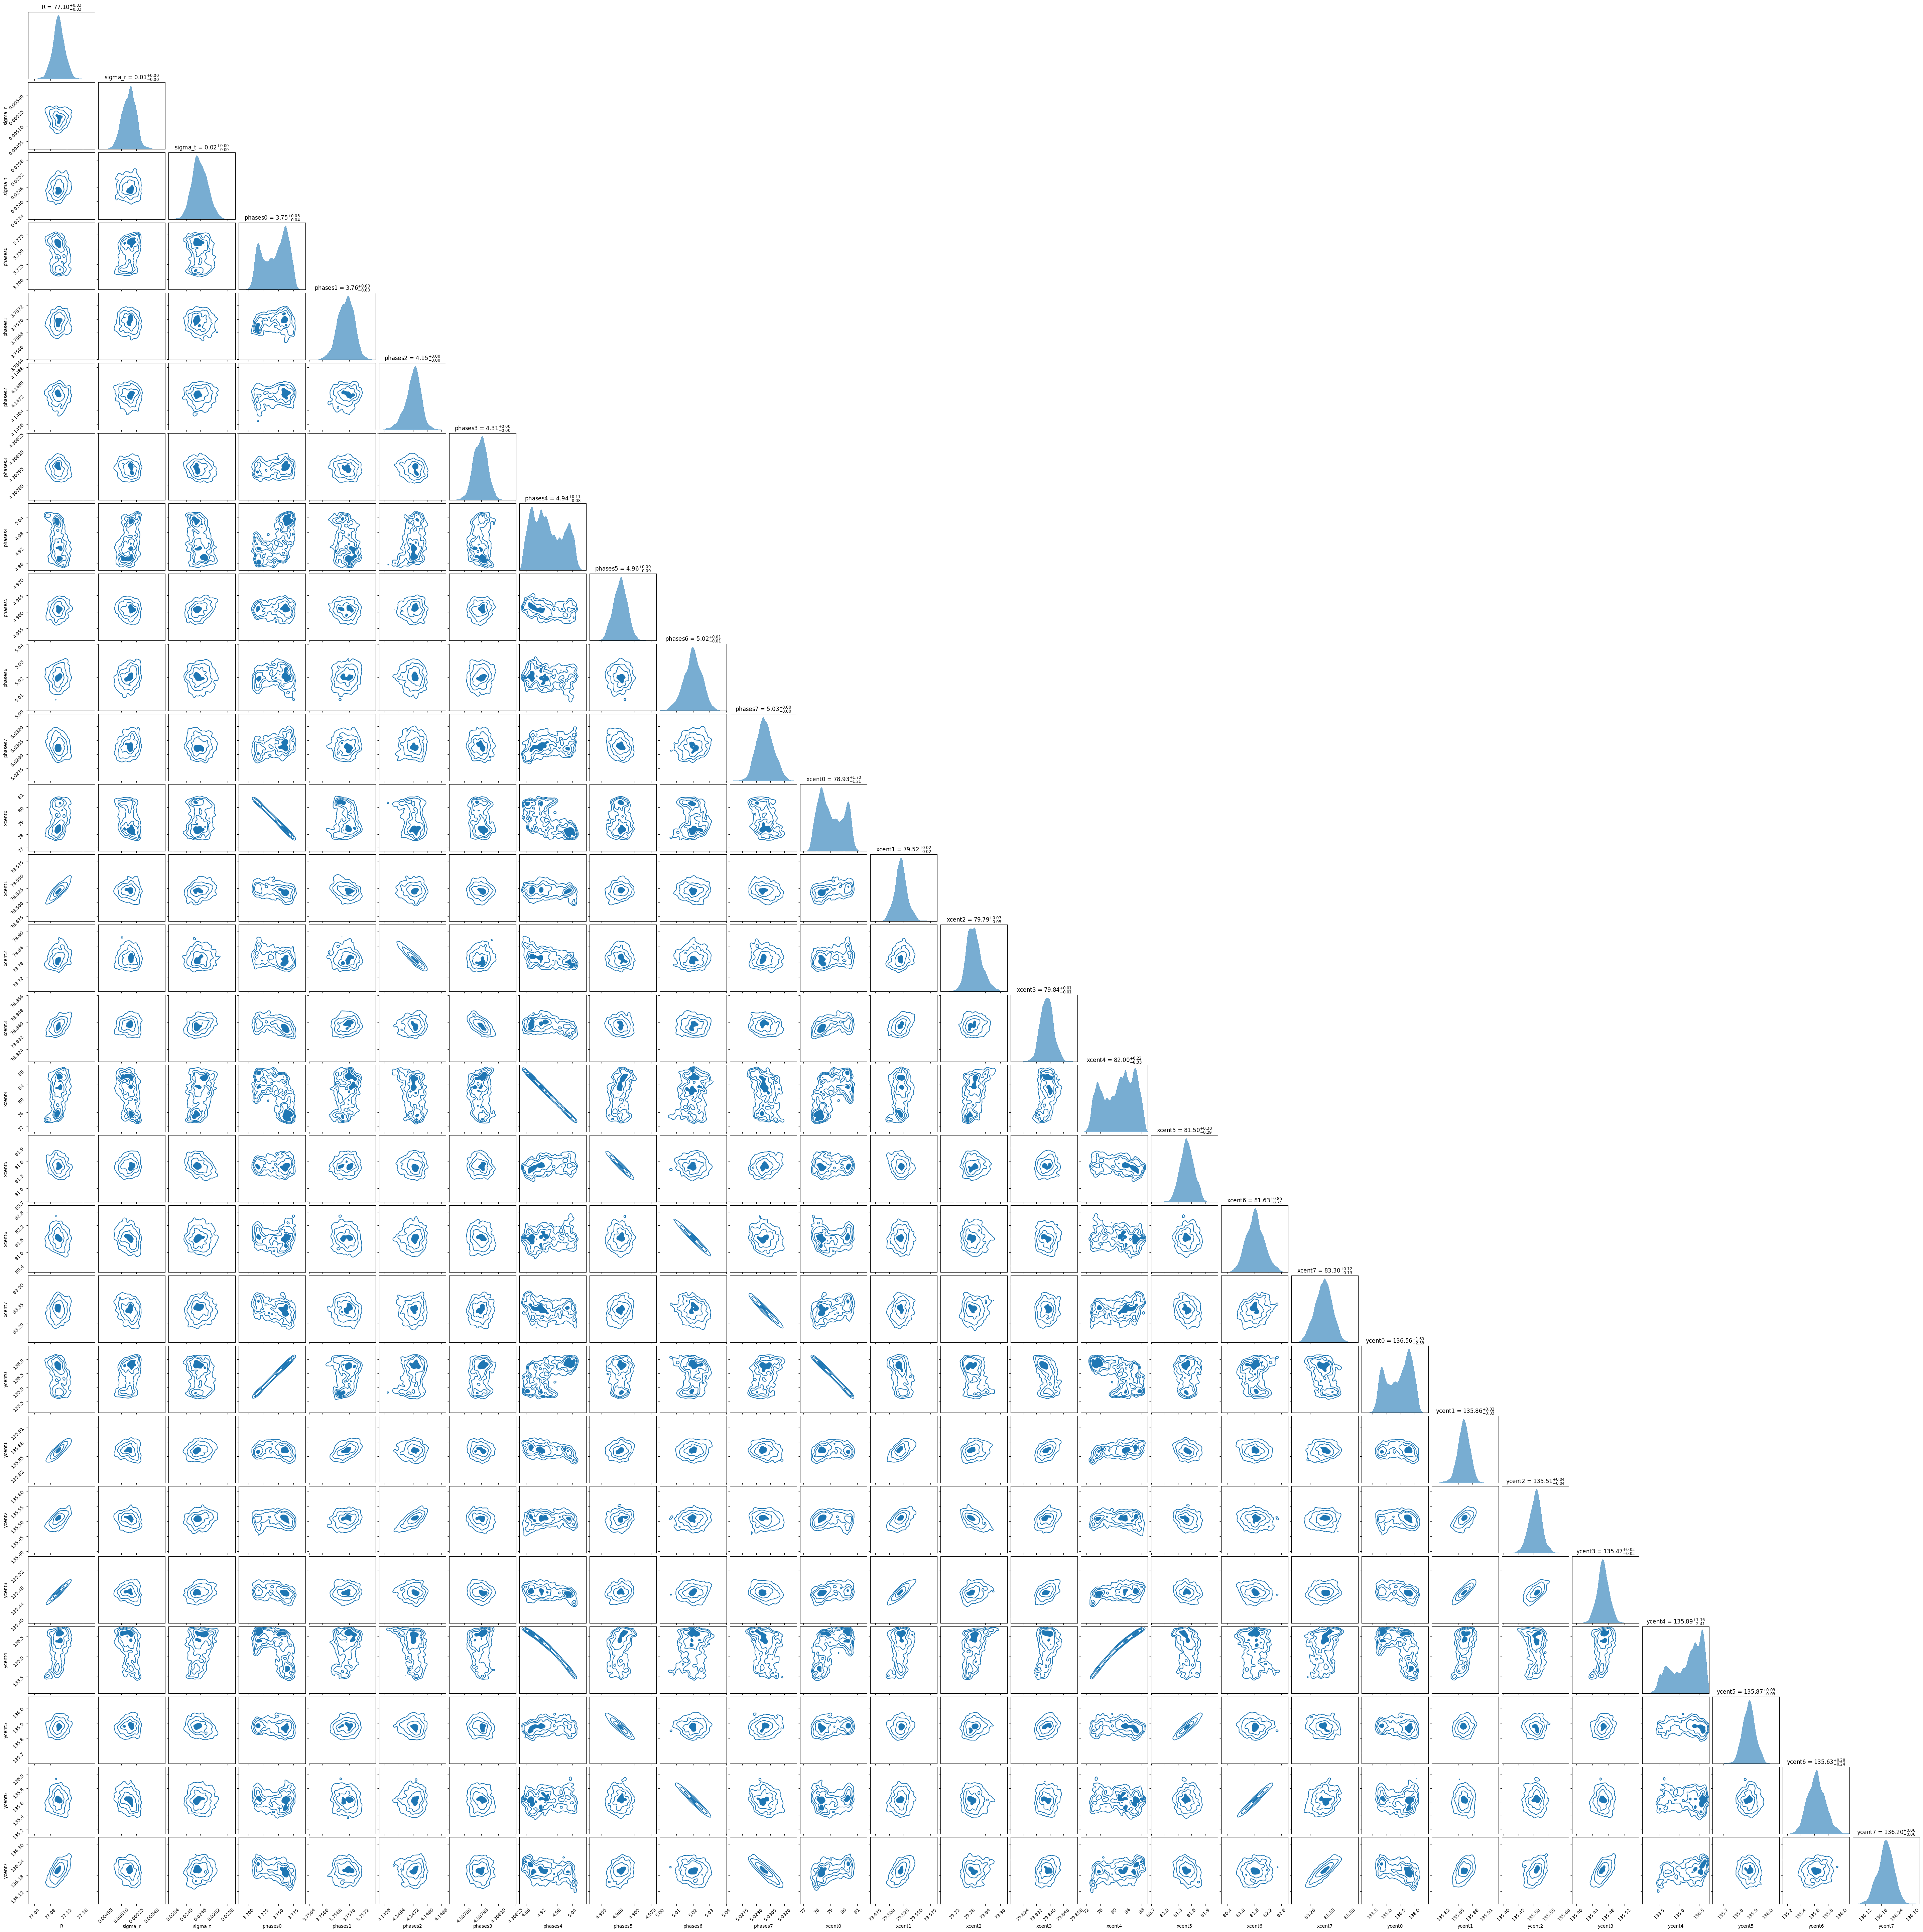

In [155]:
fg, ax = dyplot.cornerplot(fres, color='C0', labels=plabels,
                           show_titles=True, quantiles=None,)

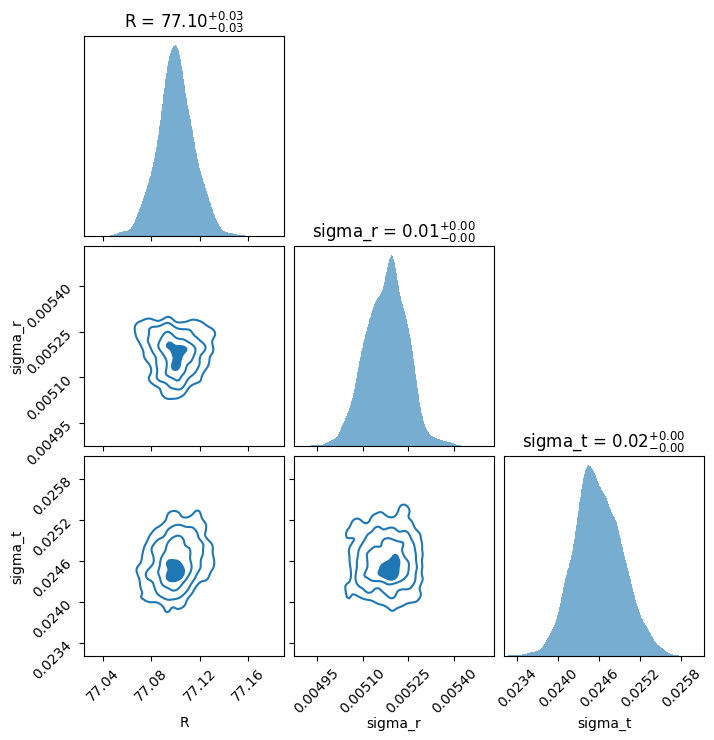

In [156]:
fg, ax = dyplot.cornerplot(fres, color='C0', labels=plabels, dims=[0,1,2],
                           show_titles=True, quantiles=None,)

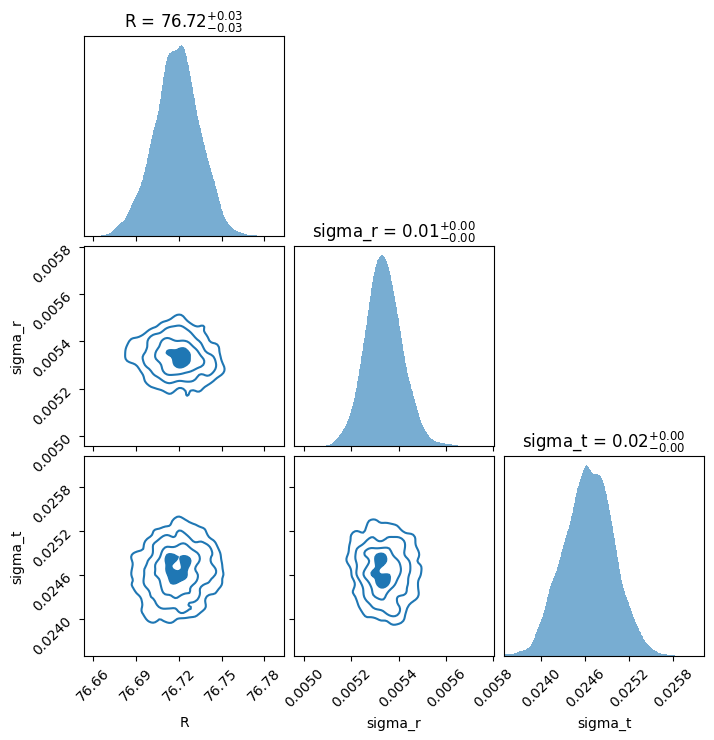

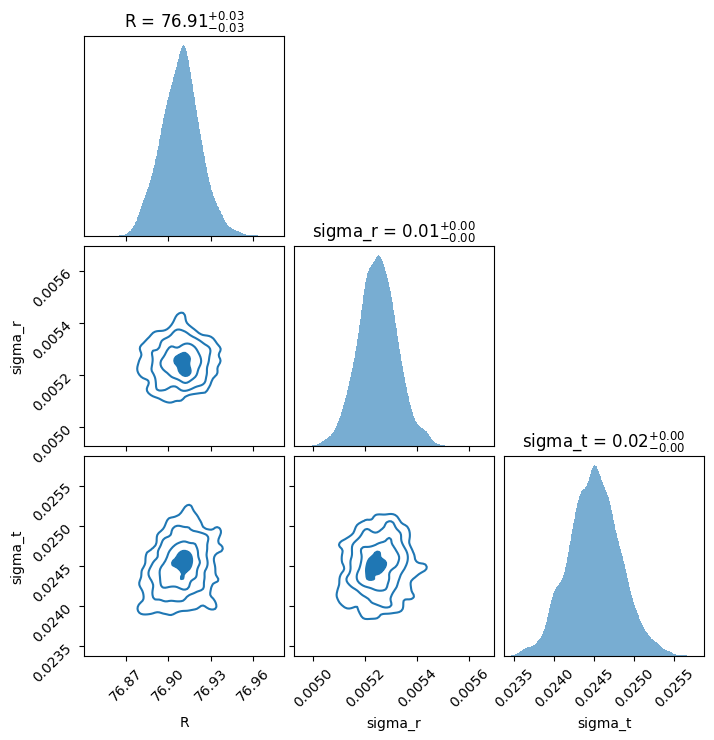

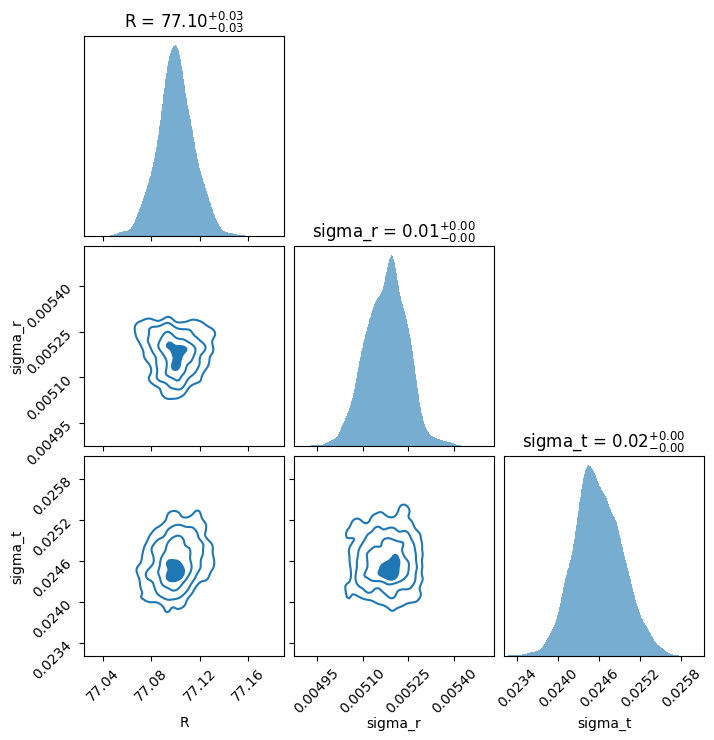

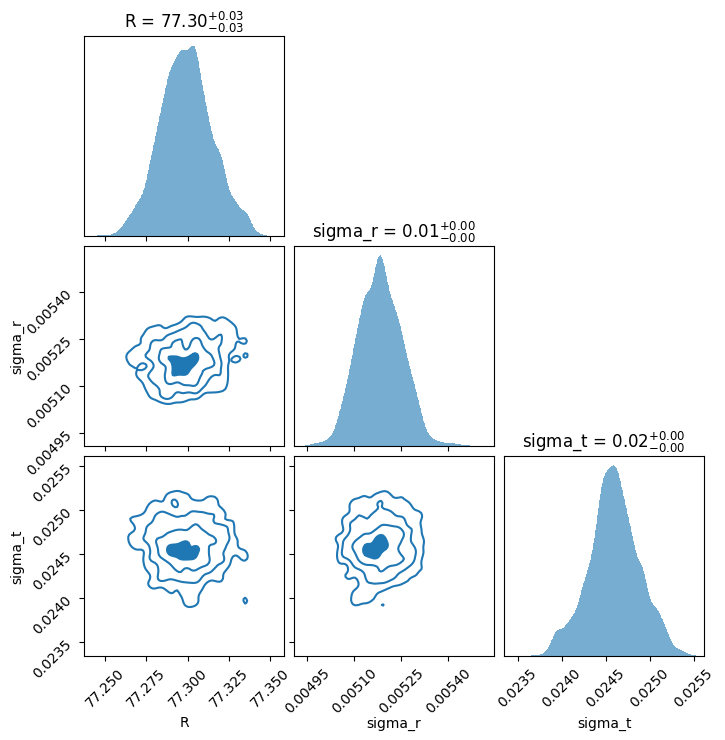

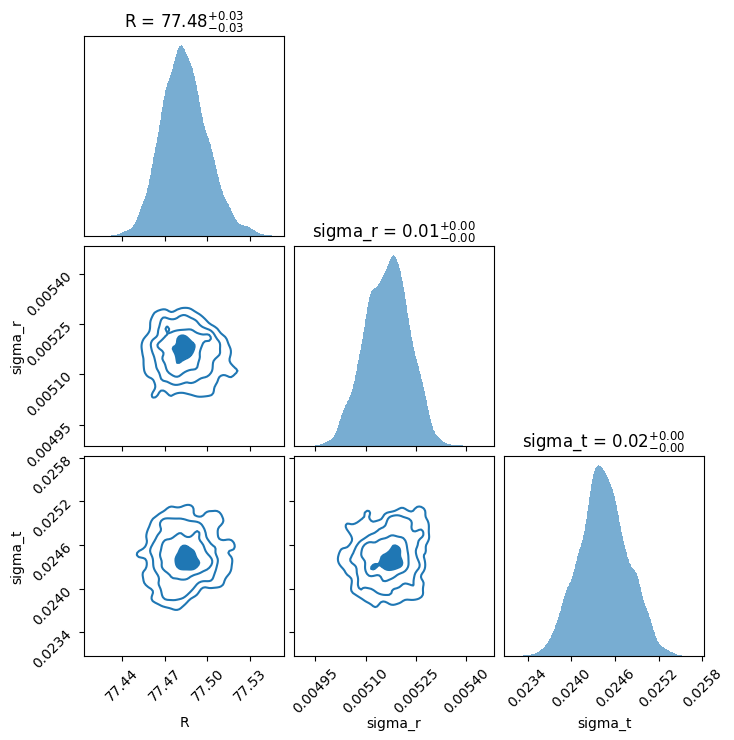

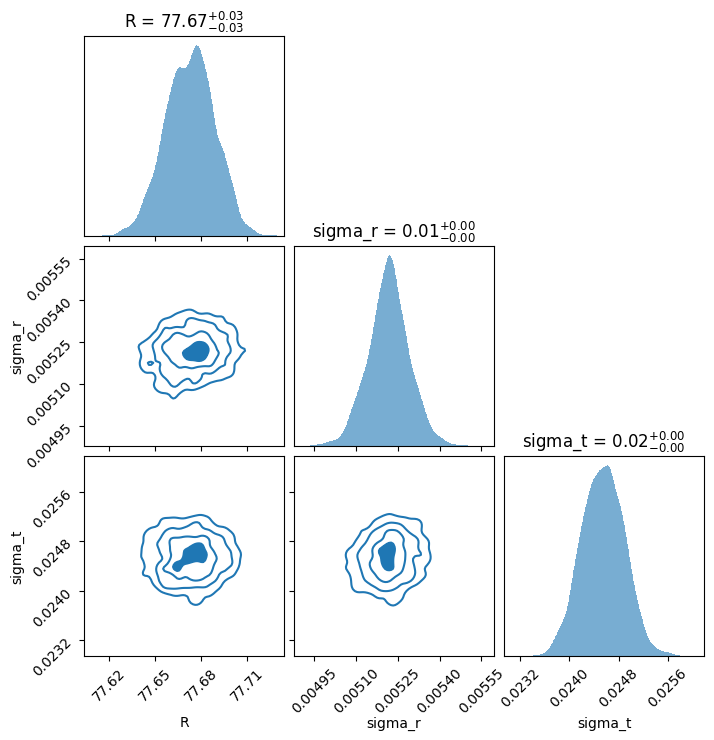

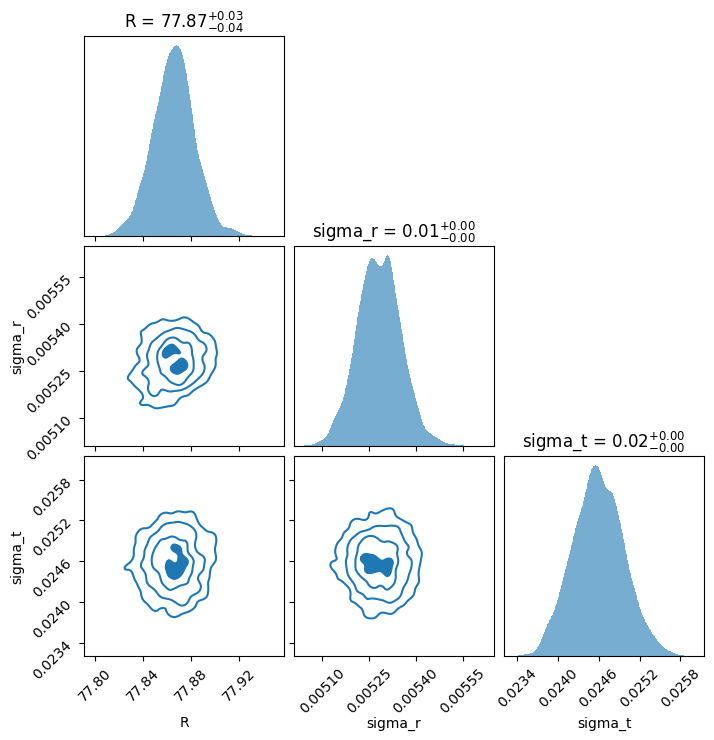

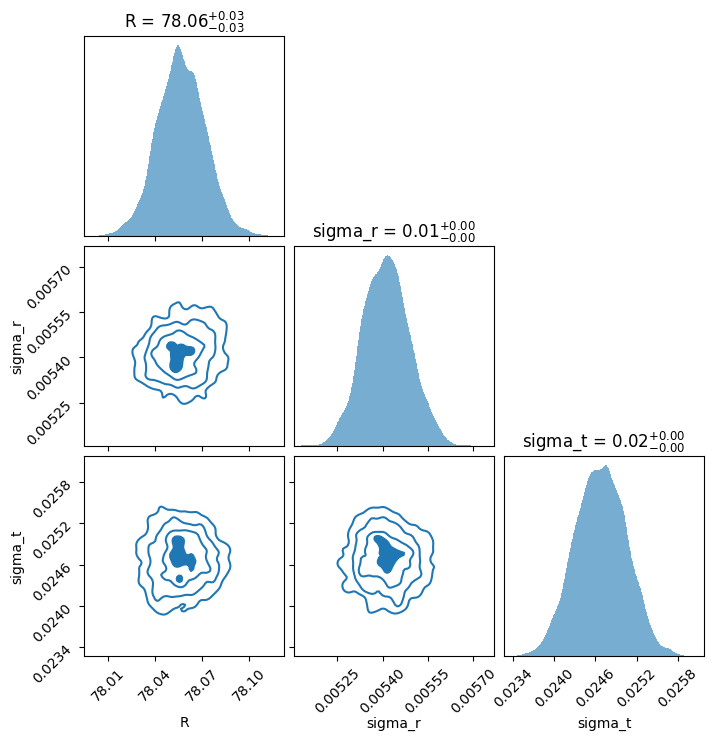

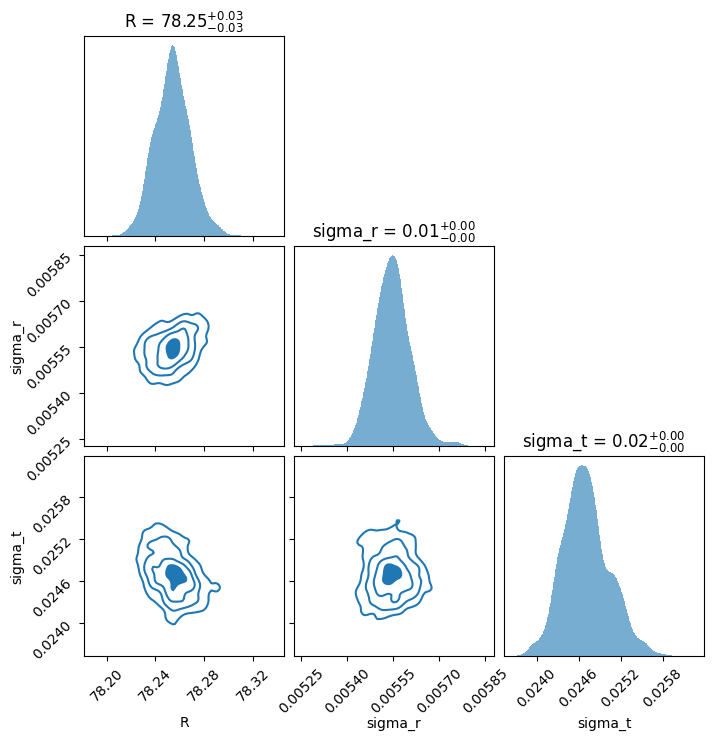

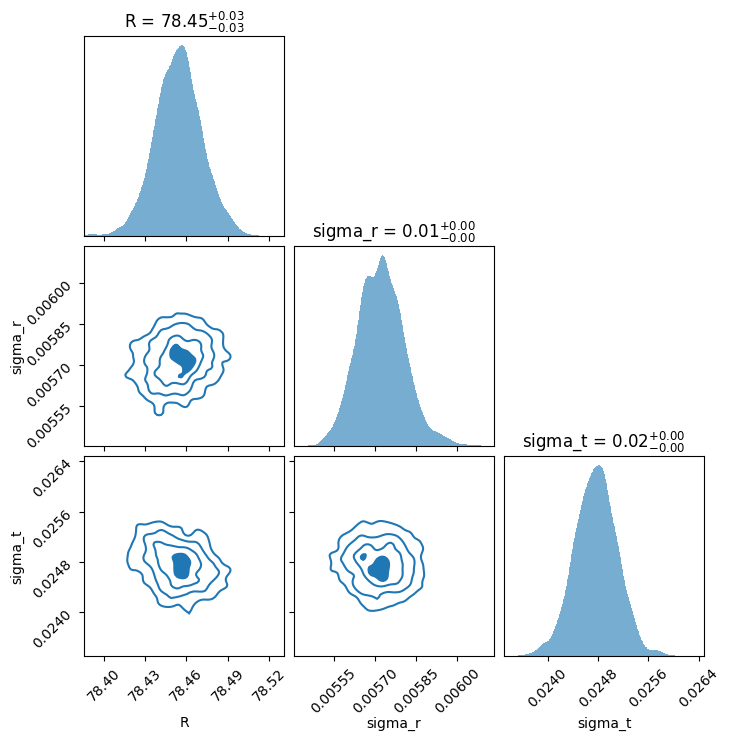

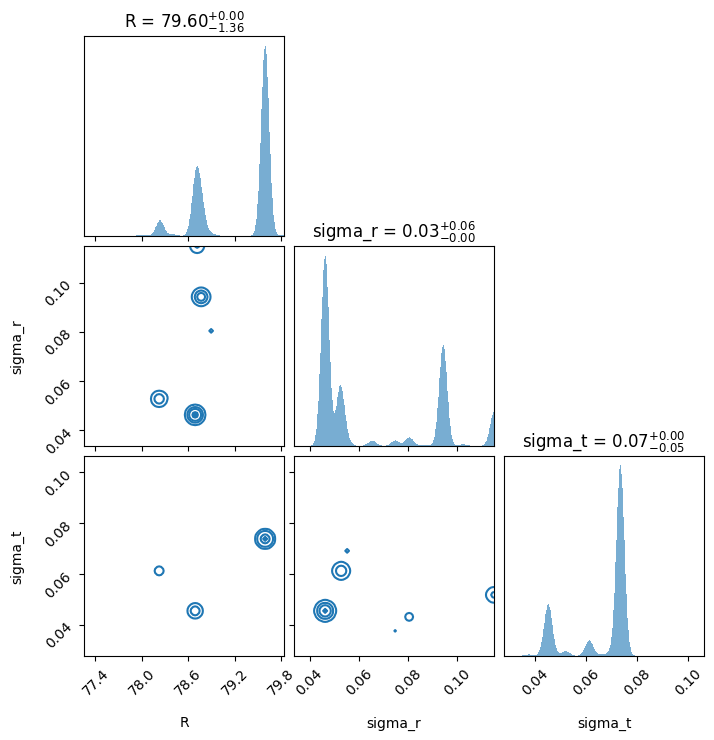

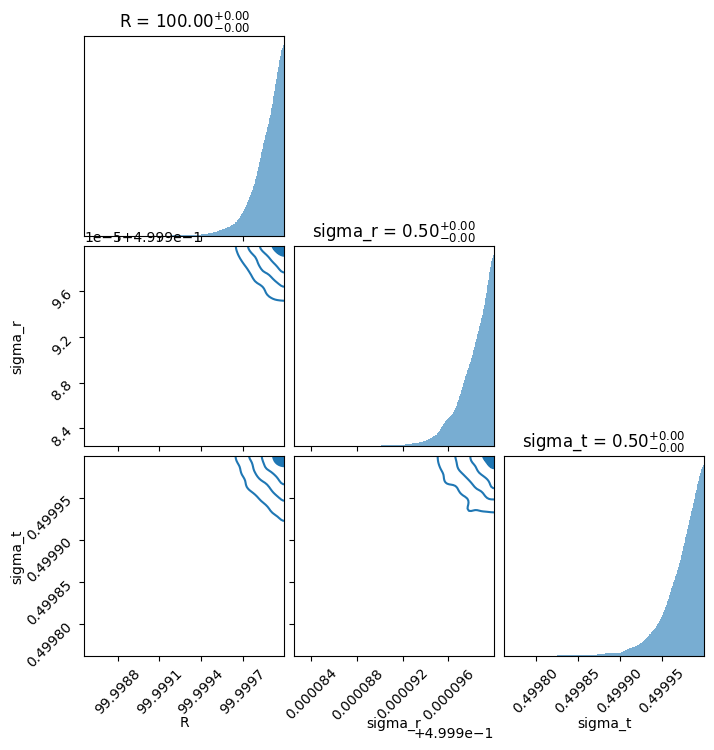

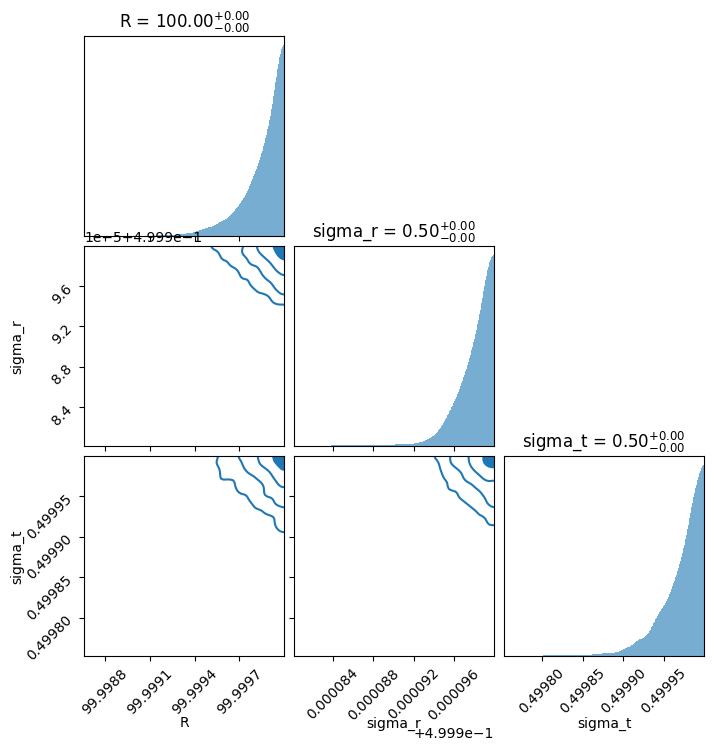

In [181]:
for n in Ns:
    fsampler = NestedSampler.restore(os.path.join(root_dir,f'dynesty_{n}.save'))
    fres = fsampler.results

    fg, ax = dyplot.cornerplot(fres, color='C0', labels=plabels, dims=[0,1,2],
                           show_titles=True, quantiles=None,)
    
    fg.savefig(os.path.join(root_dir, f"marg_posterior_{n}.png"))